# PSD for Each Ship Type for Multiple Locations

Uses pickle (json) files to get PSD data and aggregates it in SPDF plot by ship type for 3 locations.

Check following list for creation of SPDF with probabilities: https://github.com/Ocean-Data-Lab/Website-backend/blob/master/SpecGraph/SPDF.py

In [2]:
# data
import ooipy
from ooipy.tools import ooiplotlib as ooiplt
import pandas as pd
import numpy as np
#import functions as fn
# plotting
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.colors as colors
from matplotlib.colors import Normalize
from matplotlib.backends.backend_agg import FigureCanvasAgg
# IO
from io import BytesIO
import io
import json
from scipy.io import wavfile

## PSD and SPDF Plotting functions

In [3]:
def get_PSD_dict(meta_data_CSV_path, location):
    """
    Generate a dictionary that holds PSD data
    Ex. psd_dict[ship_type][freq_values] # not actual key names
    This data gets passed into the spdf generation and plotting functions
    
    Parameters
    ----------
    meta_data_CSV_path : str
        A file path that points to the .csv that contains the metadata. 
        Mainly used to group based on ship type (ud_group). Also matches instance_id
        to corresponding ship type.

    location : str
        String containing location of the hydrophone (i.e. Axial_Base).
        Used for file pathing

    Returns
    -------
    dict: a nested dictionary for ship type and their respective PSD data
    """

    df = pd.read_csv(meta_data_CSV_path, sep=',')

    # EC is the only one with missing ship type and only 4 of them, just ignore those
    # .dropna() followed by .groupby() cleans and groups
    grouped_df = df.dropna(subset=['ud_group']).groupby('ud_group')

    # https://stackoverflow.com/questions/27405483/how-to-loop-over-grouped-pandas-dataframe
    PSDs = {}
    for group_name, df_group in grouped_df:
        PSD_obj_list = []
        PSD_freq = []
        PSD_val = []
        dictPSD = {'objects': PSD_obj_list, 'frequencies': PSD_freq, 'values': PSD_val}

        # for-loop to compile list of PSD data objects pulled from column
        for row_index, row in df_group.iterrows():
            inst_id = df['instance_id'].iloc[row_index]
            # get pickle files (DL locally? Call some API?)
            # local storage method
            data_path = 'data/' + location + '/'
            pklfilepath = data_path + 'PSD_pickles/' + inst_id + '.json'
            # try-except deals with missing pickles
            try:
                with open(pklfilepath, 'rb') as f:
                    dict1 = json.load(f)

                # create PSD object and fill out PSD object fields
                psd = ooipy.Psd(dict1['f'], dict1['psd'])
                dictPSD['objects'].append(psd)
                dictPSD['frequencies'].append(psd.freq)
                dictPSD['values'].append(psd.values)
            except FileNotFoundError:
                pass
        PSDs.update({group_name: dictPSD})
    return PSDs

In [4]:
# function pulled from https://github.com/Ocean-Data-Lab/Website-backend     
def get_spdf(spec, fs_hz=200, fmax=None, spl_bins=np.linspace(0, 120, 481),
             percentiles=[1, 5, 10, 50, 90, 95, 99]):
    if fmax is None:
        fmax = 100 #spec.frequency[-1]

    n_freq_bin = int(len(spec['frequencies'][0]) * fmax/(fs_hz/2)) + 1

    spdf_dct = {'freq': np.array(np.linspace(0, fmax, n_freq_bin)),
                'spl': spl_bins[:-1],
                'pdf': np.empty((n_freq_bin, 480))
                #'number_psd': len(spec.time) this isn't used
                }

    for p in percentiles:
        spdf_dct[str(p)] = np.empty(n_freq_bin)

    for idx, freq_bin in enumerate(np.asarray(spec['values']).T[:n_freq_bin - 1]):
        hist, _ = np.histogram(freq_bin, bins=spl_bins, density=True)
        spdf_dct['pdf'][idx] = hist
        spdf_dct['50'][idx] = np.median(freq_bin)
        for p in percentiles:
            spdf_dct[str(p)][idx] = np.nanquantile(freq_bin, p/100)

    return spdf_dct

def plot_spdf(spdf, vmin=0.003, vmax=0.2, vdelta=0.0025, save=False, filename=None, log=True, title='Spectral PDF', shipType=None, location=None):
    cbarticks = np.arange(vmin, vmax+vdelta, vdelta)
    fig, ax = plt.subplots(figsize=(9, 5))
    im = ax.contourf(spdf['freq'], spdf['spl'], np.transpose(spdf['pdf']),
                     cbarticks, norm=colors.Normalize(vmin=vmin, vmax=vmax),
                     cmap='jet', extend='max', alpha=0.50, linewidth=0)

    # plot some percentiles:
    plt.plot(spdf['freq'], spdf['1'], color='black')
    plt.plot(spdf['freq'], spdf['5'], color='black')
    plt.plot(spdf['freq'], spdf['10'], color='black')
    plt.plot(spdf['freq'], spdf['50'], color='black')
    plt.plot(spdf['freq'], spdf['90'], color='black')
    plt.plot(spdf['freq'], spdf['95'], color='black')
    plt.plot(spdf['freq'], spdf['99'], color='black')

    plt.ylabel(r'spectral level (dB rel $1 \mathrm{\frac{μ Pa^2}{Hz}}$)')
    plt.xlabel('frequency (Hz)')
    plt.ylim([36, 100])
    plt.xlim([0, 90])
    if log:
        plt.xscale('log')

    plt.colorbar(im, ax=ax, ticks=[vmin, vmin + (vmax-vmin)/4, vmin + (vmax-vmin)/2,
                 vmin + 3*(vmax-vmin)/4,  vmax],  pad=0.03, label='probability', format='%.3f')
    plt.tick_params(axis='y')
    plt.grid(True)
    plt.title(title)
    handles, labels = plt.gca().get_legend_handles_labels()
    line = Line2D(
        [0], [0], label='percentiles: 1, 5, 10, 50, 90, 95, 99', color='k')
    handles.extend([line])
    plt.legend(handles=handles, loc='upper right')
    plt.tight_layout()
    plt.xlim((200/512, 100))
    filepath = 'data/'+location+'/'
    plt.savefig(filepath+shipType+'.jpg', format='jpg')
    plt.close() # suppress plotting

### Generate plots for 3 locations

In [6]:
AB_PSDs = get_PSD_dict('data/Axial_Base/AB_isolated_ais_10m_5_20.csv', location='Axial_Base')
for key in AB_PSDs:
    print((key))
    spdf = get_spdf(AB_PSDs[key])
    plot_spdf(spdf, log=False, title=key + ' Spectral PDF', shipType=key, location='Axial_Base')
    

Cargo
Fishing type
Passenger
Recreational
Research
Tanker


In [7]:
CC_PSDs = get_PSD_dict('data/Central_Caldera/CC_isolated_ais_10m_5_20.csv', location='Central_Caldera')
for key in CC_PSDs:
    print(key)
    spdf = get_spdf(CC_PSDs[key])
    plot_spdf(spdf, log=False, title=key + ' Spectral PDF', shipType=key, location='Central_Caldera')

Cargo
Fishing type
Offshore
Other purpose
Research
Tanker


In [20]:
EC_PSDs = get_PSD_dict('data/Eastern_Caldera/EC_isolated_ais_5_20.csv', location='Eastern_Caldera')
for key in EC_PSDs:
    print(key)
    spdf = get_spdf(EC_PSDs[key])
    plot_spdf(spdf, log=False, title=key + ' Spectral PDF', shipType=key, location='Eastern_Caldera')

Cargo
Fishing type
Offshore
Other purpose
Research
Tanker


In [9]:
OS_PSDs = get_PSD_dict('data/Oregon_Slope/OS_isolated_ais_5_20.csv', location='Oregon_Slope')
for key in OS_PSDs:
    print(key)
    spdf = get_spdf(OS_PSDs[key])
    plot_spdf(spdf, log=False, title=key + ' Spectral PDF', shipType=key, location='Oregon_Slope')

Cargo


C:\Users\UserALai\AppData\Local\Temp\ipykernel_13316\3414438163.py:30: UserWarning: The following kwargs were not used by contour: 'linewidth'
  im = ax.contourf(spdf['freq'], spdf['spl'], np.transpose(spdf['pdf']),


Fishing type
Other purpose
Passenger
Recreational
Tanker
drop


In [12]:
SH_PSDs = get_PSD_dict('data/Southern_Hydrate/SH_isolated_ais_5_20.csv', location='Southern_Hydrate')
for key in SH_PSDs:
    print(key)
    spdf = get_spdf(SH_PSDs[key])
    plot_spdf(spdf, log=False, title=key + ' Spectral PDF', shipType=key, location='Southern_Hydrate')

Cargo


C:\Users\UserALai\AppData\Local\Temp\ipykernel_13316\3414438163.py:30: UserWarning: The following kwargs were not used by contour: 'linewidth'
  im = ax.contourf(spdf['freq'], spdf['spl'], np.transpose(spdf['pdf']),


Fishing type
Other purpose
Passenger
Recreational
Tanker
drop


# Cepstrum Plotting
Cepstrum is in inverse (`ifft()`) of  `log(abs(FFT(signal)))`.
This gives something to use for the y-axis where x-axis would be quefrency.

Higher frequency resolution is needed, so work begins with the audio files, which we will divide into 1-minute intervals to compute the cepstrum of. Then for each vessel type (within each ud_group), we will average the cepstrums.

Can this somehow be plotted like the spdf?

In [3]:
output = wavfile.read('data/Axial_Base/Audio/AB_20150319051501_20150319052501.wav')

In [17]:
rawdf = pd.read_csv('data/Axial_Base/AB_isolated_ais_10m_5_20.csv', sep=',')

options = ['Cargo', 'Tanker', 'Fishing type']
df = rawdf[rawdf['ud_group'].isin(options)]
df = df.reset_index(drop=True)
#df = rawdf[(df['ud_group']=='Cargo') | (df['ud_group']=='Tanker') | (df['ud_group']=='Fishing type')]
# EC is the only one with missing ship type and only 4 of them, just ignore those
# .dropna() followed by .groupby() cleans and groups
grouped_df = df.dropna(subset=['ud_group', 'VESSEL TYPE']).groupby(['ud_group', 'VESSEL TYPE'])
#grouped_df.sum().tail(20)
mean_dict = {}

# Create average data
for group_name, df_group in grouped_df:
    print(group_name)
    dict = {0: [], 1: [], 2: [], 3: [], 4: [],5: [],6: [], 7: [], 8: [], 9: []}
    for row_index, row in df_group.iterrows():
        inst_id = df['instance_id'].iloc[row_index]
        #inst_id = df[df['Unnamed: 0'] == row_index]['instance_id'][0]
        # data_path = 'data/' + location + '/'
        data_path = 'data/' + 'Axial_Base' + '/'
        wavfilepath = data_path + 'Audio/' + inst_id + '.wav'
        # try-except deals with missing pickles
        try:
            output = wavfile.read(wavfilepath)
            S = output[1]
            w = int(len(S)/10) 
            time_windows = []
            for i in range(1, 11):
                """if (i == 10):
                    window = S[((i-1)*w):]
                else:
                    window = S[((i-1)*w):(i*w)]"""
                # we lose out on very last value
                window = S[((i-1)*w):(i*w)]
                time_windows.append(window)

            # to see time_windows output
            for idx, wind in enumerate(time_windows):
                #print(f'window {idx}: {wind}')
                #print(f'Window {idx} shape is {wind.shape}')
                # compute cf
                cf = (np.log(np.abs(np.fft.fft(wind))))
                if (len(wind) == 12000):
                    dict[idx].append(cf)
                #print(dict[idx][0])
                #plt.plot(cf)

        except FileNotFoundError:
            pass
    # time windows for this group filled out @ this point
    group_cf_mean = 0
    for i in range(len(dict)):
        group_cf_mean += np.mean(dict[i][0], axis=0)
    group_cf_mean /= len(dict)
    mean_dict.update({str(group_name): group_cf_mean})


('Cargo', 'Bulk Carrier')
('Cargo', 'Cargo')
('Cargo', 'General Cargo')
('Cargo', 'Vehicles Carrier')
('Cargo', 'Wood Chips Carrier')
('Fishing type', 'Fishing Vessel')
('Fishing type', 'Towing Vessel')
('Fishing type', 'Tug')
('Tanker', 'Crude Oil Tanker')
('Tanker', 'LPG Tanker')
('Tanker', 'Oil Products Tanker')
('Tanker', 'Oil/Chemical Tanker')


In [16]:
np.mean(dict[i][1])

IndexError: list index out of range

key: ('Cargo', 'Bulk Carrier'), values: ()
key: ('Cargo', 'Cargo'), values: ()
key: ('Cargo', 'General Cargo'), values: ()
key: ('Cargo', 'Vehicles Carrier'), values: ()
key: ('Cargo', 'Wood Chips Carrier'), values: ()
key: ('Fishing type', 'Fishing Vessel'), values: ()
key: ('Fishing type', 'Towing Vessel'), values: ()
key: ('Fishing type', 'Tug'), values: ()
key: ('Tanker', 'Crude Oil Tanker'), values: ()
key: ('Tanker', 'LPG Tanker'), values: ()
key: ('Tanker', 'Oil Products Tanker'), values: ()
key: ('Tanker', 'Oil/Chemical Tanker'), values: ()


FileNotFoundError: [Errno 2] No such file or directory: "data/Axial_Base/Cepstrum/('Tanker', 'Oil/Chemical Tanker').jpg"

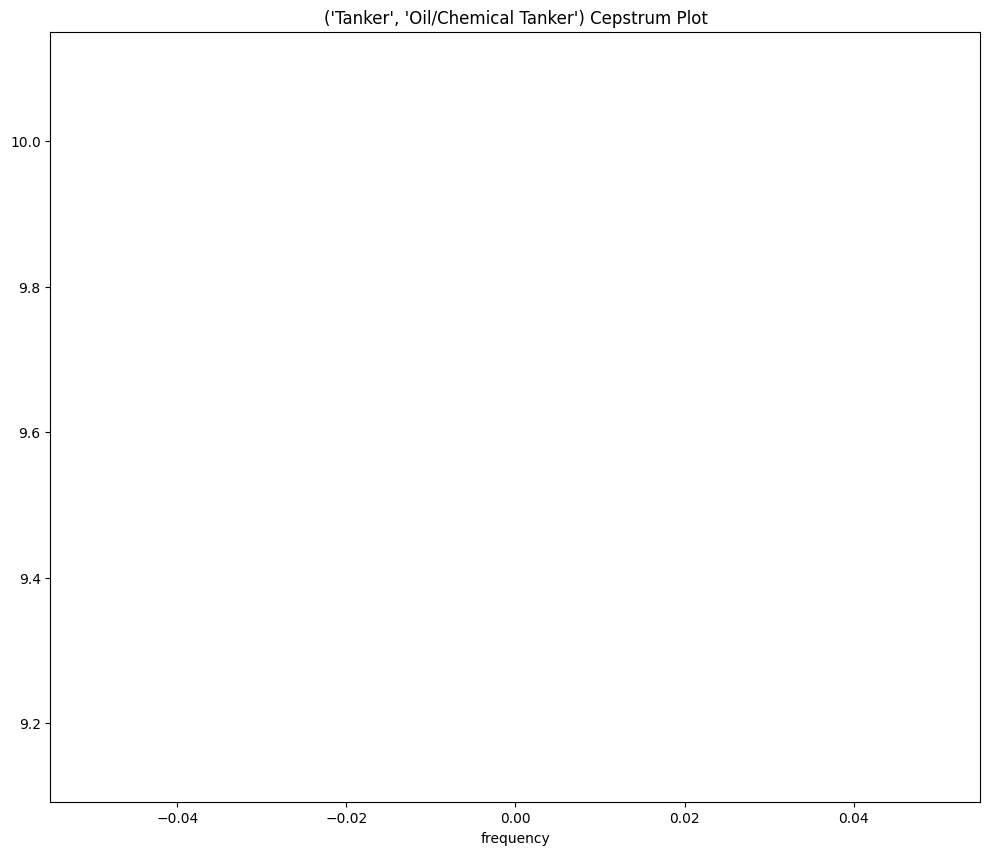

In [18]:
for k, v in mean_dict.items():
    plt.subplots(figsize=(12, 10))
    print(f'key: {k}, values: {v.shape}')
    plt.plot(mean_dict[k])
    plt.xlabel('frequency')
    #plt.xscale('log')
    plt.title(k + ' Cepstrum Plot')
    plt.savefig('data/Axial_Base/Cepstrum/'+ k + '.jpg', format='jpg')
    plt.close()

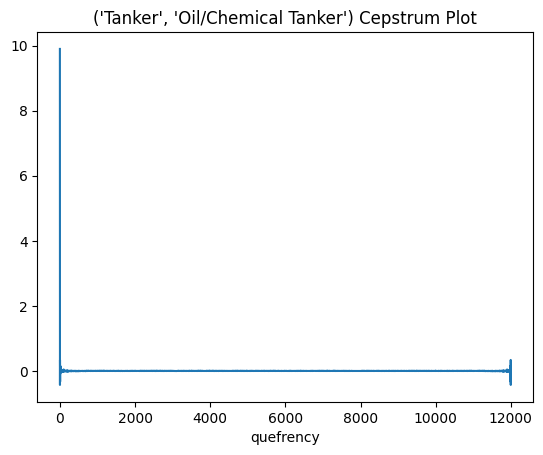

In [265]:
plt.plot(mean_dict['(\'Tanker\', \'Oil/Chemical Tanker\')'])
plt.xlabel('quefrency')
plt.title(k + ' Cepstrum Plot')
plt.savefig('data/Axial_Base/Cepstrum/(\'Tanker\', \'Oil Chemical Tanker\').jpg', format='jpg')

In [253]:
for k, v in mean_dict.items():
    print(k[2])

C
C
C
C
C
F
F
F
T
T
T
T


c:\Users\UserALai\miniconda3\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


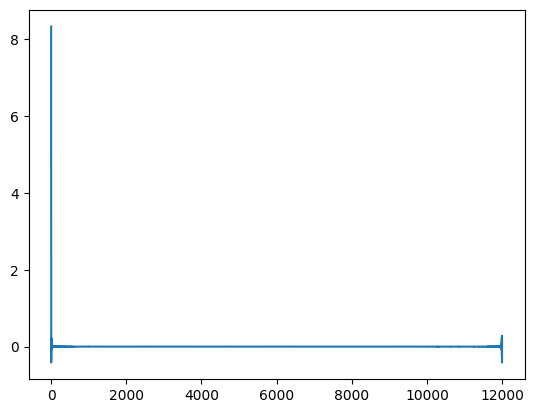

In [241]:
plt.plot(mean_dict["('Cargo', 'Bulk Carrier')"])